## Dropout with LSTM Network for Time Series Forecasting

Long Short-Term Memory (LSTM) models are a type of recurrent neural network capable of learning sequences of observations. Thus, they are well-suited to time series forecasting. 

Because LSTMs can easily overfit training data, I employ a dropout regularization method. In this technique, input and recurrent connections to LSTM units are probabilistically excluded from activation and weight updates while training the network. This has the effect of reducing overfitting and improving model performance.

#### Load and plot dataset

We will be using a shampoo sales dataset which describes the monthly number of sales of shampoo over a 3-year period.

        Month  Sales
0  1901-02-01  145.9
1  1901-03-01  183.1
2  1901-04-01  119.3
3  1901-05-01  180.3
4  1901-06-01  168.5


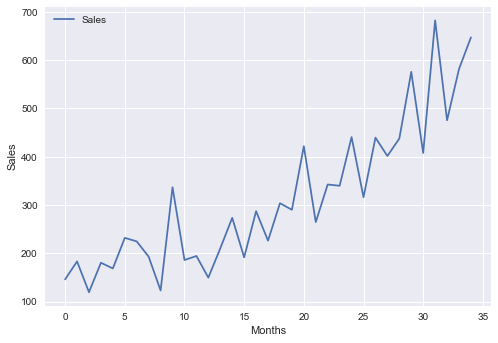

In [2]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("seaborn")

# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('shampoo-sales.csv')
series.columns = 'Month','Sales'
# summarize first few rows
print(series.head())

# line plot
ax = series.plot()
ax.set_xlabel('Months')
ax.set_ylabel('Sales')
plt.show()

## Experiment

### Data Split

Split dataset into training and test set. 

The first 2 years of data will be used as the training data and the final year will be used as the test set. 

The persistence forecast (naive forecast) on the test dataset achieves an error of 136.761 monthly shampoo sales. This provides a lower acceptable bound of performance on the test set.

### Model evaluation

A rolling-forecast scenario will be used (aka walk-forward model validation).

Each time step of the test dataset will be walked one at a time. A model will be used to make a forecast for the time step, then the actual expected value from the test set will be taken and made available to the model for the forecast on the next time step.

This mimics a real-world scenario where new Shampoo Sales observations would be available each month and used in the forecasting of the following month.

This will be simulated by the structure of the train and test datasets.

All forecasts on the test dataset will be collected and an error score calculated to summarize the skill of the model. The root mean squared error (RMSE) will be used as it punishes large errors and results in a score that is in the same units as the forecast data, namely monthly shampoo sales.

## Data Preparation

Before we can fit a model to the dataset, we must transform the data.

The following three data transforms are performed on the dataset prior to fitting a model and making a forecast.

   1. __Transform the time series data so that it is stationary__. Specifically, a lag=1 differencing to remove the increasing trend in the data.
   2. __Transform the time series into a supervised learning problem__. Specifically, the organization of data into input and output patterns where the observation at the previous time step is used as an input to forecast the observation at the current time step.
   3. __Transform the observations to have a specific scale__. Specifically, to rescale the data to values between -1 and 1.
    
These transforms are inverted on forecasts to return them into their original scale before calculating and error score.

## LSTM Model

We will use a base stateful LSTM model with 1 neuron fit for 1000 epochs.

A batch size of 1 is required as we will be using walk-forward validation and making one-step forecasts for each of the final 12 months of test data.

A batch size of 1 means that the model will be fit using online training (as opposed to batch training or mini-batch training). As a result, it is expected that the model fit will have some variance.

Ideally, more training epochs would be used (such as 1500), but this was truncated to 1000 to keep run times reasonable.

The model will be fit using the efficient ADAM optimization algorithm and the mean squared error loss function.

### Experimental Runs

Each experimental scenario will be run 30 times and the RMSE score on the test set will be recorded from the end each run.

## Baseline LSTM Model

Let's start off with the baseline LSTM model.

The baseline LSTM model for this problem has the following configuration:

   - Lag inputs : 1
   - Epochs : 1000
   - Units in LSTM hidden layer : 3
   - Batch Size : 4
   - Repeats : 3
    
This code listing will be used as the basis for all following experiments, with only the changes to this code listing provided in subsequent sections.

In [9]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, n_batch, nb_epoch, n_neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=bn_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# run a repeated experiment
def experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons):
    # transform data to be stationary
    raw_values = series.values
    diff_values = difference(raw_values, 1)
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, n_lag)
    supervised_values = supervised.values[n_lag:,:]
    # split data into train and test-sets
    train, test = supervised_values[0:-12], supervised_values[-12:]
    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)
    # run experiment
    error_scores = list()
    for r in range(n_repeats):
        # fit the model
        train_trimmed = train_scaled[2:, :]
        lstm_model = fit_lstm(train_trimmed, n_batch, n_epochs, n_neurons)
        # forecast test dataset
        test_reshaped = test_scaled[:,0:-1]
        test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
        output = lstm_model.predict(test_reshaped, batch_size=n_batch)
        predictions = list()
        for i in range(len(output)):
            yhat = output[i,0]
            X = test_scaled[i, 0:-1]
            # invert scaling
            yhat = invert_scale(scaler, X, yhat)
            # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
            # store forecast
            predictions.append(yhat)
        # report performance
        rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_scores.append(rmse)
    return error_scores

# configure the experiment
def run():
    # load dataset
    series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
    # configure the experiment
    n_lag = 1
    n_repeats = 30
    n_epochs = 1000
    n_batch = 4
    n_neurons = 3
    # run the experiment
    results = DataFrame()
    results['results'] = experiment(series, n_lag, n_repeats, n_epochs, n_batch, n_neurons)
    # summarize results
    print(results.describe())
    # save boxplot
    results.boxplot()
    pyplot.savefig('experiment_baseline.png')

# entry point
run()

C:\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Anaconda2\envs\py35\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Anaconda2\envs\py35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Anaconda2\envs\py35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Anaconda2\envs\py35\lib\

ValueError: In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size. Found: 19 samples